# Parallel Processing in Python

An obvious way to improve the performance of Python code is to make it run in parallel. Any relatively new computer will have multiple cores, which means that several processors can operate on the same data stored on memory. However, most of the code we have written in the course so far does not take advantage of more than one of them. In addition there is now widespread availability of computing clusters, such as [those offered for use by Amazon](http://aws.amazon.com/ec2/) (Vanderbilt also has [its own cluster](http://www.accre.vanderbilt.edu)). Clusters allow several computers to work together by exchanging data over a network.

Parallel computing involves breaking a task into several independent sub-tasks, distributing these sub-tasks to available processors or computers, then coordinating the execution of these tasks and combining their outputs in an appropriate way.

There are several different models for parallel processing, including:

* **Message passing**: processes or other program components running in parallel communicate by sending and receiving messages, which allows for easy synchronization. 
* **Multi-threading**: within a single process, some architectures allow for the existence of several "threads", which execute independently, though they share the memory and state of the process in which they reside. Multi-threading is good for increasing *throughput* and reducing *latency*.
* **Task farming**: a master process delegates independent calculations to available processors (task farm), and collects their outputs when complete.
* **Single program, multiple data (SPMD)** Probably the most common type of parallel processing, in which tasks are split up and run simultaneously on multiple processors with different input in order to obtain results faster. All tasks execute their copy of the same program simultaneously.
* **Multiple program, multiple data (MPMD)** Like SPMD, except each task may be executing a different program.

## `multiprocessing`

The simplest way (though probably not the best) for performing parallel computing in Python is via the built-in process-based library for concurrent computing, called `multiprocessing`. 

In [1]:
import multiprocessing
import os
import numpy as np

The `multiprocessing` module parallelizes by launching multiple *processes*, each with a seperate interpretor. You may have already heard about *threads*. Processes and threads are not the same:

* processes are independent of one another, each having their own state, memory and address spaces
* threads share resources, and are therefore interdependent; they are subunits of the same process

Since processes are independent, they now have independent Global Interpreter Locks (GILs),  its best to run multiprocessing on multiple CPUs. You can check how many you have on your machine:

In [2]:
multiprocessing.cpu_count()

4

### `Process` class

The `Process` class encapsulates a task running in a process. It will usually have a `target` argument that is some callable (function/method) that is executed when the process runs, along with optional arguments that can be passed to the target.

A `Process` has several methods, with some useful ones being:

* `is_alive`: Returns `True` if the process is running.
* `join`: Waits for the process to finish its work and terminate. An optional `timeout` argument can be passed.
* `run`: When the process starts, this method is called to invoke the `target`.
* `terminate`: Kills the process forcibly, without any cleanup.

A `Process` also has several other non-callable attributes, such as `pid`, `name` and `authkey`.

Here is a trivial example of using the `Process` class, showing that each has its own process ID.

In [3]:
import os

def job(n):
    print('I am working on job {0} running on PID {1}'.format(n, os.getpid()))

jobs = []
for i in range(5):
    p = multiprocessing.Process(target=job, args=(i,))
    jobs.append(p)
    p.start()

I am working on job 0 running on PID 18970
I am working on job 1 running on PID 18971
I am working on job 2 running on PID 18972
I am working on job 3 running on PID 18973
I am working on job 4 running on PID 18974


In [4]:
jobs

[<Process(Process-1, stopped)>,
 <Process(Process-2, stopped)>,
 <Process(Process-3, stopped)>,
 <Process(Process-4, stopped)>,
 <Process(Process-5, stopped)>]

We can easily subclass `Process` to our liking:

In [5]:
class FibProcess(multiprocessing.Process):
    
    def __init__(self, n):
        self.n = n
        multiprocessing.Process.__init__(self)
        
    def run(self):
        a, b = 0, 1
        for i in range(self.n):
            a, b = b, a + b

In [6]:
p = FibProcess(10000)
p.start()
print(p.pid)
p.join()
print(p.exitcode)

18975
0


### `Queue` class

Of course, despite being independent, we would like our processes to communicate with one another, for example, to share data. One way to facilitate this in `multiprocessing` is via the `Queue` class, a thread/process safe, first-in-first-out (FIFO) data structure that can store any serializable Python object.

A `Queue`'s important methods include:

* `put`: Adds item to `Queue`.
* `get`: Fetches next item from `Queue`.
* `close`: Closes the `Queue`, preventing the addition of more data.
* `empty`: Returns True if the `Queue` is empty.
* `full`: Returns True if full.
* `qsize`: Retuns approximate current number of items in `Queue`.

A subclass of `Queue` is the `JoinableQueue`, which has additional methods, notably `join`, which waits until all the items have been processed, blocking the addition of new items.


In [7]:
from multiprocessing import Queue

q = Queue()

q.put(-1)
q.put('foobar')
q.put(5)

print(q.get())
print(q.get())

-1
foobar


Here's a toy example of `Queue` usage, where a process is fed items from a function, until it receives a `None` object.

First, a function to execute a task with items from a `Queue`:

In [8]:
def consumer(q):
    while True:
        thing = q.get()
        if thing is None:
            break
        print('Consuming {}'.format(thing))
    print("\nFinished consuming")

Complementing this is another function that provisions the `Queue` with items:

In [9]:
def producer(sequence, q):
    for thing in sequence:
        q.put(thing)

Initialize the `Queue` and start the `consumer` process:

In [10]:
queue = multiprocessing.Queue()

consumer_process = multiprocessing.Process(target=consumer, args=[queue])
consumer_process.start()

Consuming 42
Consuming foobar
Consuming True
Consuming range(0, 5)

Finished consuming


Feed the `Queue` and process until finished:

In [11]:
stuff = [42, 'foobar', True, range(5)]
producer(stuff, queue)

In [12]:
queue.put(None)
consumer_process.join()

Two things to be aware of:

1. if you `terminate` a process that is still accessing a queue, the queue may become corrupted
2. you should make sure that any queue to which a given process has given data is clear before joining the process, or you will get a deadlock condition

### `Pool` class

We often have a task that we want to split up among several worker processes in parallel. The `Pool` class creates a number of processes and the methods for passing work to them. A `Pool` has the following key methods:

* `apply`: Executes a passed function in a process and returns the result.
* `apply_async`: Same as apply, but the result is returned asynchronously via a *callback*
* `map`: A parallel version of `apply`, which splits an iterable of data into chunks and farms chunks out to processes.
* `map_async`: Asynchronous `map`.

### Example: parallel bootstrap

As an example, we will choose a statistical computing task that is [*embarassingly parallel*](http://en.wikipedia.org/wiki/Embarrassingly_parallel). This function generates statistics of bootstrapped samples from a dataset.

In [13]:
def bootstrap(data, nsamples, f):
    boot_samples = data[np.random.randint(len(data), size=(nsamples, len(data)))]
    return [f(s) for s in boot_samples]

In [14]:
pool = multiprocessing.Pool(processes=4)

In [15]:
some_data = np.random.poisson(4, 25)

In [16]:
result = pool.apply_async(bootstrap, (some_data, 1000, np.mean))

The result is an `ApplyResult` object:

In [17]:
result

We may then want to take the result and calculate a confidence interval based on the quantiles.

In [18]:
def bootstrap_ci(boot, alpha=0.05): 
    
    lower_index = int(np.floor((0.5*alpha)*len(boot)))
    upper_index = int(np.floor((1.-0.5*alpha)*len(boot)))
    return boot[lower_index], boot[upper_index]

In [19]:
bootstrap_ci(np.sort(result.get()))

(2.52, 4.0800000000000001)

In [20]:
# Clean up
pool.close()
pool.join()

But, since we used `Pool.apply`, this is not a parallel task. We need to use `map`.

In [21]:
def mapped_bootstrap(n): 
    return bootstrap(some_data, n, np.mean)

In [22]:
pool = multiprocessing.Pool(processes=4)

In [23]:
map_result = pool.map_async(mapped_bootstrap, [250]*4)

In [24]:
map_result

In [25]:
parallel_results = map_result.get()
[len(p) for p in parallel_results]

[250, 250, 250, 250]

In [26]:
bootstrap_ci(np.sort(np.ravel(parallel_results)))

(2.4399999999999999, 4.1200000000000001)

In [27]:
pool.close()
pool.join()

The multiprocessing package is very useful for highly parallel tasks that do not need to communicate with each other, other than when sending the initial data to the pool of processes and when and collecting the results. 

## Jupyter parallel

The IPython architecture consists of four components, which reside in the `ipyparallel` package:

1. **Engine** The IPython engine is a Python instance that accepts Python commands over a network connection.  When multiple engines are started, parallel and distributed computing becomes possible. An important property of an IPython engine is that it blocks while user code is being executed. 

2. **Hub** The hub keeps track of engine connections, schedulers, clients, as well as persist all task requests and results in a database for later use.

3. **Schedulers** All actions that can be performed on the engine go through a Scheduler. While the engines themselves block when user code is run, the schedulers hide that from the user to provide a fully asynchronous interface to a set of engines.

4. **Client** The primary object for connecting to a cluster.

![IPython architecture](images/ipython_architecture.png)
(courtesy Min Ragan-Kelley)

This architecture is implemented using the ØMQ messaging library and the associated Python bindings in `pyzmq`.

## Start your engines!

In order to use IPython for parallel computing, you will need to start the IPython
controller and two or more IPython engines. The simplest way of doing this is
with the [clusters tab](/#tab2), or you can use the `ipcluster` command in a terminal:

    $ ipcluster start --n=4

This command will start 4 IPython engines on the current host, which is appropriate for many desktop multicore systems. You can also setup IPython clusters that span many nodes in a computing cluster, but this is beyond the scope of this lecture, but you can get more information from 
[the IPython.parallel docs](http://ipython.org/ipython-doc/dev/parallel/parallel_process.html)..

To use the IPython cluster in our Python programs or notebooks, we start by creating an instance of `ipyparallel.Client`:

In [28]:
from ipyparallel import Client

In [32]:
cli = Client()

This creates a client using the default profile; you can pass an optional `profile="my_profile"` argument if you have a different one running.

Using the `ids` attribute we can retreive a list of ids for the IPython engines in the cluster:

In [33]:
cli.ids

[0, 1]

We can use a `DirectView` object for execution of tasks, which an be accessed simply by indexing the client:

In [34]:
dv0 = cli[0]
dv0

<DirectView 0>

The above shows just a single engine, but we want all of them:

In [35]:
dview = cli[:]
dview

<DirectView [0, 1]>

We can get a view on whatever combination of engines we want:

In [36]:
cli[::2]

<DirectView [0]>

In [37]:
cli[1::2]

<DirectView [1]>

The `block` flag specifies whether to wait for the result, or return an `AsyncResult` object immediately:

In [38]:
dview.block = True

Finally, since we want to use IPython's parallel magic commands, we set the `DirectView` to be `active`:

In [39]:
dview.activate()

Each of these engines are ready to execute tasks. We can selectively run code on individual engines. For example, we can simply use `os.getpid` to return the process ID that the engine is running on. Here is the notebook process:

In [40]:
import os
os.getpid()

18949

Here is a single engine's process ID:

In [41]:
dv0.apply_sync(os.getpid)

18993

And here are all the engines, run simultaneously:

In [42]:
dview.apply_sync(os.getpid)

[18993, 18994]

Let's now consider a useful function that we might want to run in parallel. Here is a version of the approximate Bayesian computing (ABC) algorithm that we have seen in previous lectures.

In [43]:
import numpy

def abc(y, N, epsilon=[0.2, 0.8]):
    
    trace = []

    while len(trace) < N:

        # Simulate from priors
        mu = numpy.random.normal(0, 10)
        sigma = numpy.random.uniform(0, 20)

        x = numpy.random.normal(mu, sigma, 50)

        #if (np.linalg.norm(y - x) < epsilon):
        if ((abs(x.mean() - y.mean()) < epsilon[0]) &
            (abs(x.std() - y.std()) < epsilon[1])):
            trace.append([mu, sigma])

    return trace

In [44]:
import numpy as np

y = np.random.normal(4, 2, 50)

Let's try running this on one of the cluster engines:

In [45]:
dv0.block = True
dv0.apply(abc, y, 10)

RemoteError: NameError(name 'numpy' is not defined)

This fails with a `NameError` because NumPy has not been imported on the engine to which we sent the task. Each engine has its own namespace, so we need to import whatever modules we will need  prior to running our code:

In [46]:
cli[0].execute("import numpy")

<AsyncResult: execute>

In [47]:
dv0.apply(abc, y, 10)

[[4.729794501294109, 1.955124275924458],
 [4.4084785969434535, 3.2710801621330976],
 [5.1924225245376245, 2.6639991076064917],
 [4.914692595106862, 2.943457251742494],
 [5.598432333216517, 2.1019281233409504],
 [4.847396141714309, 1.7678739019246792],
 [4.775530891472667, 2.3076434075853958],
 [5.181119280045877, 2.295797728233673],
 [5.11601758179679, 1.8056184659746566],
 [5.359761108209431, 2.880568354850497]]

A more efficient way is to simultaneously import modules into the local and the engine namespaces simultaneously, using a context manager:

In [48]:
with dview.sync_imports():
    import numpy

importing numpy on engine(s)


In [49]:
t = dview.apply(abc, y, 10)

Easier yet, you can use the parallel cell magic to import everywhere:

In [50]:
%%px
import numpy

You can also use the `require` decorator for functions that you wish to use on engines.

In [51]:
from ipyparallel import require

@require("numpy")
def abc(y, N, epsilon=[0.2, 0.8]):

    trace = []

    while len(trace) < N:

        # Simulate from priors
        mu = numpy.random.normal(0, 10)
        sigma = numpy.random.uniform(0, 20)

        x = numpy.random.normal(mu, sigma, 50)

        #if (np.linalg.norm(y - x) < epsilon):
        if ((abs(x.mean() - y.mean()) < epsilon[0]) &
            (abs(x.std() - y.std()) < epsilon[1])):
            trace.append([mu, sigma])

    return trace

A simple way to run code on an engine is via the `execute` method:

In [52]:
dv0.execute('x=3')

<AsyncResult: execute:finished>

In [53]:
dv0['x']

3

### Data transfer

We will often want to send data to our engines, or retrieve objects from them. `DirectView` has `push` and `pull` methods for achieving this.

Recall that Python namespaces are just dictionaries. So, we can update an engine's namespace by pushing a dictionary:

In [54]:
dv0.push({'foo': -3, 'bar': np.arange(10)})

In [55]:
dv0.pull(('x', 'bar'))

[3, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

Additionally, `DirectView` objects also have `scatter` and `gather` methods, to distribute data among engines. `scatter` accepts any container or Numpy `array` type, while `gather` assembles the respective return objects in the Client.

In [56]:
# Some Gaussian data
y

array([  3.49322828,   5.30494559,   3.6189018 ,   6.75997796,
        -0.21334747,   2.42591587,   7.25860593,   5.79365828,
         4.3719095 ,   4.8857659 ,   5.41098905,   2.65143428,
         5.23338454,   7.31421719,   5.97221326,   7.15798182,
         7.17905784,   8.16824998,   6.11871443,   4.17446774,
         9.53597307,   8.11262697,   2.08434239,   3.6807146 ,
         6.60156969,   3.77160205,   1.10850621,   3.0781838 ,
         5.38484312,   5.30269602,   6.78573415,   4.60953635,
         5.43390477,   4.09052607,   7.48890093,   4.50875377,
         4.77165189,   6.6224069 ,   2.80725959,   3.68837268,
         6.85987156,   4.05963832,   4.95305724,   3.10880789,
         2.47886851,   2.65170513,   4.8583221 ,   3.79538796,
         4.00783596,  10.26270091])

In [57]:
dview = cli[:2]

In [58]:
# Send to engines
dview.scatter('y', y)
dview['y']

[array([ 3.49322828,  5.30494559,  3.6189018 ,  6.75997796, -0.21334747,
         2.42591587,  7.25860593,  5.79365828,  4.3719095 ,  4.8857659 ,
         5.41098905,  2.65143428,  5.23338454,  7.31421719,  5.97221326,
         7.15798182,  7.17905784,  8.16824998,  6.11871443,  4.17446774,
         9.53597307,  8.11262697,  2.08434239,  3.6807146 ,  6.60156969]),
 array([  3.77160205,   1.10850621,   3.0781838 ,   5.38484312,
          5.30269602,   6.78573415,   4.60953635,   5.43390477,
          4.09052607,   7.48890093,   4.50875377,   4.77165189,
          6.6224069 ,   2.80725959,   3.68837268,   6.85987156,
          4.05963832,   4.95305724,   3.10880789,   2.47886851,
          2.65170513,   4.8583221 ,   3.79538796,   4.00783596,  10.26270091])]

In [59]:
# Remote execution of function
dview.execute('sum_y = sum(y)')

<AsyncResult: execute>

In [60]:
# Aggregation on client
sum(dview.gather('sum_y'))

249.58457238955828

The `map` method essentially combines `scatter` and `gather` into a single call:

In [61]:
dview.map(lambda x: sum(x**2), np.split(y, 5))

<AsyncMapResult: <lambda>>

### Load balancing

The `DirectView` objects we have used so far strictly allocate particular tasks to particular engines. This is often inefficient, when tasks take variable amounts of time, leaving some engines idle while some are overworked. We can use a **load balanced** view to distribute memory approximately equally among engines, to minimize idle time.

In [62]:
lb_view = cli.load_balanced_view()
lb_view

<LoadBalancedView None>

A `LoadBalancedView`, though it works with all the engines (or specified subsets of engines), behaves as if it is working with a single engine.

If you do not specify the engines when the `LoadBalancedView` is created, it will use all the engines that are available when it assigns tasks.

In [63]:
for i in range(10):
    pid = lb_view.apply_sync(os.getpid)
    print('Task {0} ran on process {1}'.format(i, pid))

Task 0 ran on process 18993
Task 1 ran on process 18994
Task 2 ran on process 18993
Task 3 ran on process 18994
Task 4 ran on process 18993
Task 5 ran on process 18994
Task 6 ran on process 18993
Task 7 ran on process 18994
Task 8 ran on process 18993
Task 9 ran on process 18994


In [64]:
%%px

def abc(y, N, epsilon=[0.2, 0.8]):

    trace = []

    while len(trace) < N:

        # Simulate from priors
        mu = numpy.random.normal(0, 10)
        sigma = numpy.random.uniform(0, 20)

        x = numpy.random.normal(mu, sigma, 50)

        #if (np.linalg.norm(y - x) < epsilon):
        if ((abs(x.mean() - y.mean()) < epsilon[0]) &
            (abs(x.std() - y.std()) < epsilon[1])):
            trace.append([mu, sigma])

    return trace

In [65]:
tasks = lb_view.map_async(lambda n: abc(y, n), [20]*5)

In [66]:
tasks.msg_ids

['551c609d-e842-4fe3-b25d-f6bf1425991b',
 '6c30b36f-47e6-4d72-9de3-56d464ae8756',
 '68d30d90-84dd-4b0f-a83d-41454668a660',
 'a3dd0b4a-9497-495c-a85b-cd40860ae881',
 'f7eeb9fd-96dc-4ad5-bcd2-12a22c4efabf']

In [67]:
result = np.concatenate(tasks.get())
result[:10]

array([[ 5.13479778,  1.99074744],
       [ 5.83737441,  2.80446401],
       [ 4.93086704,  2.78291914],
       [ 5.07532547,  2.89403202],
       [ 5.57137057,  1.58596582],
       [ 5.22463293,  2.65868058],
       [ 4.52186877,  2.81636134],
       [ 5.49863421,  1.61619842],
       [ 5.24600375,  1.74222543],
       [ 5.5639975 ,  1.67952349]])

Another way that you can dispatch tasks to engines is via the `parallel` decorator. This decorator is a method of the `DirectView` class that controls our engine pool. The decorated function is then disparched to the engines using the `map` method that the decorator adds to the class.

In [68]:
@lb_view.parallel(block=True)
def abc(y, N, epsilon=[0.2, 0.8]):
    
    trace = []

    while len(trace) < N:

        # Simulate from priors
        mu = numpy.random.normal(0, 10)
        sigma = numpy.random.uniform(0, 20)

        x = numpy.random.normal(mu, sigma, 50)

        #if (np.linalg.norm(y - x) < epsilon):
        if ((abs(x.mean() - y.mean()) < epsilon[0]) &
            (abs(x.std() - y.std()) < epsilon[1])):
            trace.append([mu, sigma])

    return trace

In [69]:
abc.map([y]*4, [25]*4)

[[[5.099682864276421, 1.9600016451620506],
  [5.167619695345338, 2.7749820165169115],
  [4.65741013915943, 2.744966364750392],
  [4.631512967150718, 2.2170096764352754],
  [4.912050459991287, 1.9205491182111745],
  [4.535967735211762, 2.091694516734597],
  [5.300889064301683, 2.9545139934122444],
  [4.756953973918762, 1.6123588265695288],
  [5.506509682307172, 2.643826970085197],
  [5.143915920591466, 1.596264678271515],
  [5.058542066042192, 2.2487972003157997],
  [4.893977094678111, 1.7820732690578045],
  [5.089788438659532, 1.7566732396821627],
  [4.828081550671436, 3.4737089991803827],
  [5.097180224631751, 2.45113231616515],
  [4.830565010283392, 2.4955384226959487],
  [5.251808785167854, 1.3646424428460269],
  [5.268592126423453, 1.3681561718947721],
  [5.103207452428124, 2.378189165650919],
  [4.357701820937493, 3.088604471573273],
  [5.5757420529349035, 2.3391659934899067],
  [4.51170901539765, 1.787305543407789],
  [4.805618531567692, 1.9544731262002468],
  [4.6593154012349265

### Parallel magics

The `%px` cell magic is a "parallel execution" statement, which will run the code in that cell on all the engines.

In [70]:
%%px 
import os
print(os.getpid())

[stdout:0] 18993
[stdout:1] 18994


In [71]:
%px b = numpy.random.random()

In [72]:
%px b

Out[0:5]: 0.5779141088162374

Out[1:5]: 0.2809837962562448

`%pxresult` displays the output of the last request:

In [73]:
%pxresult

Out[0:5]: 0.5779141088162374

Out[1:5]: 0.2809837962562448

The `%pxconfig` magic allows you to configure blocking for the parallel magics.

In [74]:
# Switch to asynchronous
%pxconfig --block

Remember that each engine is just another IPython, so anyting you can do in an IPython session you can also do on an engine.

In [75]:
%px %matplotlib inline

In [76]:
%px samples = abc(y, 100)

[output:0]

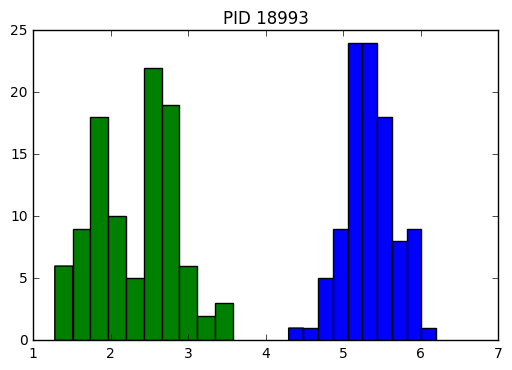

[output:1]

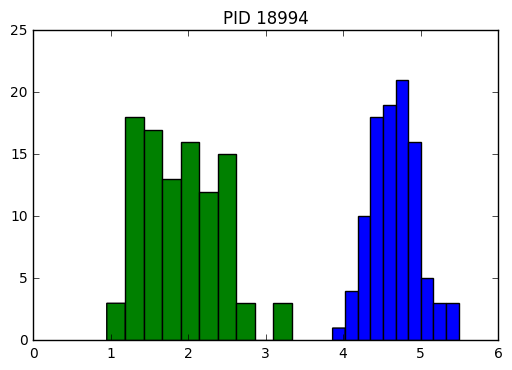

In [77]:
%%px 
import matplotlib.pyplot as plt
import os
tsamples = numpy.transpose(samples)
plt.hist(tsamples[0])
plt.hist(tsamples[1])
_ = plt.title('PID %i' % os.getpid())

For profiling, we can also use the `%timeit` magic to compare performance on the engines:

In [78]:
%%px
%%timeit
s = abc(y, 10)

[stdout:0] 1 loop, best of 3: 809 ms per loop
[stdout:1] 1 loop, best of 3: 646 ms per loop


## Cython Parallel

In order to use Cython in parallel on IPython, we need to load and execute `cythonmagic` on all engines.

In [79]:
%px %load_ext cython

As an example, let's use the Cythonized Gibbs sampler from the last lecture.

In [80]:
%%px
%%cython

from numpy import zeros, random
from numpy cimport *
from libc.math cimport sqrt
gamma = random.gamma
normal = random.normal

def gibbs(int N=20000, int thin=200):
    cdef: 
        ndarray[float64_t, ndim=2] mat = zeros((N,2))
        float64_t x,y = 0
        int i,j
    for i in range(N):
        for j in range(thin):
            x = gamma(3, y**2 + 4)
            y = normal(1./(x+1), 1./sqrt(2*(x+1)))
        mat[i] = x,y

    return mat

Divide the array by the number of nodes.  In this case they divide evenly, a more general partitioning of sizes is easy to do as well.

In [81]:
cli.ids

[0, 1]

In [82]:
N = 100000
thin = 10
n = N/len(cli.ids)
dv = cli[:]
dv.push(dict(n=n, thin=thin))
# Let's just confirm visually we got what we expect
dv['n']

[50000.0, 50000.0]

We can time the execution of the gibbs sampler on the remote nodes

In [83]:
%pxconfig --noblock

In [84]:
%timeit dv.execute('gibbs(n, thin)')

100 loops, best of 3: 2.12 ms per loop


But a more realistic (and costly) benchmark must also include the cost of bringing the results back from the cluster engines to our local namespace.  For that, we assign the call to the variable `a` on each node and then use the view's `gather` method to pull them back in:

In [85]:
%%timeit
dv.execute('a = gibbs(n, thin)')
a = dv.gather('a')

The slowest run took 4.56 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 6.19 ms per loop


Let's compare this to the same number of samples executed on a single process:

In [86]:
%load_ext cython

In [87]:
%%cython

from libc.math cimport sqrt
from numpy import zeros, random
from numpy cimport *
gamma = random.gamma
normal = random.normal

def gibbs(int N=20000, int thin=200):
    cdef: 
        ndarray[float64_t, ndim=2] mat = zeros((N,2))
        float64_t x,y = 0
        int i,j
    for i in range(N):
        for j in range(thin):
            x = gamma(3, y**2 + 4)
            y = normal(1./(x+1), 1./sqrt(2*(x+1)))
        mat[i] = x,y

    return mat

In [88]:
%%timeit 
a = gibbs(N, thin)

1 loop, best of 3: 1.07 s per loop


## Exercise

Run parallel chains of the `disaster_model` example from PyMC and return the resulting traces to your client, for plotting and summarization.

In [89]:
# Write your answer here

## References

[Scientific Python Lectures](http://github.com/jrjohansson/scientific-python-lectures) by Robert Johansson

[Using IPython for Parallel Computing](http://ipython.org/ipython-doc/dev/parallel/)